In [1]:
import pandas as pd
import numpy as np
import rebound
import matplotlib.pyplot as plt
from matplotlib import colors
from rebound.interruptible_pool import InterruptiblePool
import scipy.optimize as opt

In [2]:
from celmech.disturbing_function import df_coefficient_Ctilde
from celmech.disturbing_function import evaluate_df_coefficient_dict
from celmech.disturbing_function import laplace_b as b

In [3]:
def b1(alpha):
    return b(1.5, 1, 0, alpha)
def b2(alpha):
    return b(1.5, 2, 0, alpha)

In [4]:
def GtoS(alpha, mass, ecc, pomega):
    alpha12, alpha23 = alpha
    alpha13 = alpha12*alpha23
    m1, m2, m3 = mass
    m_tot = m1+m2+m3
    ecc1, ecc2, ecc3 = ecc
    pom1, pom2, pom3 = pomega

    e1_x, e2_x, e3_x = ecc1*np.cos(pom1), ecc2*np.cos(pom2), ecc3*np.cos(pom3)
    e1_y, e2_y, e3_y = ecc1*np.sin(pom1), ecc2*np.sin(pom2), ecc3*np.sin(pom3)
    
    w2 = 2*m2/(m1+m3) * (m1/(np.pi*(1-alpha23)**2) + m3/(np.pi*(1-alpha12)**2)) + 2*(m1+m3)/(np.pi*(1-alpha13)**2)
    w3 = 2*m_tot/(m1+m3) * (m1/(np.pi*(1-alpha12)**2) + m3/(np.pi*(1-alpha23)**2))
    k = np.sqrt(m1*m2*m3*m_tot)/(m1+m3) * (2/(np.pi*(1-alpha23)**2) - 2/(np.pi*(1-alpha12)**2))
    phi = 1/2*np.arctan2(2*k, w2-w3)
    
    S1_x = np.sqrt(1/m_tot)*(m1*e1_x + m2*e2_x + m3*e3_x)
    S1_y = np.sqrt(1/m_tot)*(m1*e1_y + m2*e2_y + m3*e3_y)
    S2_x = np.cos(phi)*(np.sqrt(m1*m3/(m1+m3))*(e3_x-e1_x)) + np.sin(phi)*np.sqrt(m2/((m1+m3)*m_tot))*(m3*(e3_x-e2_x)-m1*(e2_x-e1_x))
    S2_y = np.cos(phi)*(np.sqrt(m1*m3/(m1+m3))*(e3_y-e1_y)) + np.sin(phi)*np.sqrt(m2/((m1+m3)*m_tot))*(m3*(e3_y-e2_y)-m1*(e2_y-e1_y))
    S3_x = -np.sin(phi)*(np.sqrt(m1*m3/(m1+m3))*(e3_x-e1_x)) + np.cos(phi)*np.sqrt(m2/((m1+m3)*m_tot))*(m3*(e3_x-e2_x)-m1*(e2_x-e1_x))
    S3_y = -np.sin(phi)*(np.sqrt(m1*m3/(m1+m3))*(e3_y-e1_y)) + np.cos(phi)*np.sqrt(m2/((m1+m3)*m_tot))*(m3*(e3_y-e2_y)-m1*(e2_y-e1_y))
    
    amp1, amp2, amp3 = np.sqrt(S1_x**2+S1_y**2), np.sqrt(S2_x**2+S2_y**2), np.sqrt(S3_x**2+S3_y**2)
    phase1, phase2, phase3 = np.arctan2(S1_y,S1_x), np.arctan2(S2_y,S2_x), np.arctan2(S3_y,S3_x)
    omega2, omega3 = w2*(np.cos(phi))**2 + k*np.sin(2*phi) + w3*(np.sin(phi))**2, w2*(np.sin(phi))**2 - k*np.sin(2*phi) + w3*(np.cos(phi))**2
    
    return amp1, amp2, amp3, phase1, phase2, phase3, omega2, omega3, phi

In [5]:
def StoG(mass, amp, phase, phi):
    m1, m2, m3 = mass
    m_tot = m1+m2+m3
    A1, A2, A3 = amp
    p1, p2, p3 = phase
    
    e1_x = 1/np.sqrt(m1) * (np.sqrt(m1/m_tot)*A1*np.cos(p1) + (-np.cos(phi)*np.sqrt(m3/(m1+m3)) + np.sin(phi)*np.sqrt(m1*m2/(m_tot*(m1+m3))))*A2*np.cos(p2) + (np.sin(phi)*np.sqrt(m3/(m1+m3)) + np.cos(phi)*np.sqrt(m1*m2/(m_tot*(m1+m3))))*A3*np.cos(p3))
    e2_x = 1/np.sqrt(m2) * (np.sqrt(m2/m_tot)*A1*np.cos(p1) - np.sin(phi)*np.sqrt((m1+m3)/m_tot)*A2*np.cos(p2) - np.cos(phi)*np.sqrt((m1+m3)/m_tot)*A3*np.cos(p3))
    e3_x = 1/np.sqrt(m3) * (np.sqrt(m3/m_tot)*A1*np.cos(p1) + (np.cos(phi)*np.sqrt(m1/(m1+m3)) + np.sin(phi)*np.sqrt(m2*m3/(m_tot*(m1+m3))))*A2*np.cos(p2) + (-np.sin(phi)*np.sqrt(m1/(m1+m3)) + np.cos(phi)*np.sqrt(m2*m3/(m_tot*(m1+m3))))*A3*np.cos(p3))
    
    e1_y = 1/np.sqrt(m1) * (np.sqrt(m1/m_tot)*A1*np.sin(p1) + (-np.cos(phi)*np.sqrt(m3/(m1+m3)) + np.sin(phi)*np.sqrt(m1*m2/(m_tot*(m1+m3))))*A2*np.sin(p2) + (np.sin(phi)*np.sqrt(m3/(m1+m3)) + np.cos(phi)*np.sqrt(m1*m2/(m_tot*(m1+m3))))*A3*np.sin(p3))
    e2_y = 1/np.sqrt(m2) * (np.sqrt(m2/m_tot)*A1*np.sin(p1) - np.sin(phi)*np.sqrt((m1+m3)/m_tot)*A2*np.sin(p2) - np.cos(phi)*np.sqrt((m1+m3)/m_tot)*A3*np.sin(p3))
    e3_y = 1/np.sqrt(m3) * (np.sqrt(m3/m_tot)*A1*np.sin(p1) + (np.cos(phi)*np.sqrt(m1/(m1+m3)) + np.sin(phi)*np.sqrt(m2*m3/(m_tot*(m1+m3))))*A2*np.sin(p2) + (-np.sin(phi)*np.sqrt(m1/(m1+m3)) + np.cos(phi)*np.sqrt(m2*m3/(m_tot*(m1+m3))))*A3*np.sin(p3))
    
    e1, e2, e3 = np.sqrt(e1_x**2 + e1_y**2), np.sqrt(e2_x**2 + e2_y**2), np.sqrt(e3_x**2 + e3_y**2)
    pom1, pom2, pom3 = np.arctan2(e1_y,e1_x), np.arctan2(e2_y,e2_x), np.arctan2(e3_y,e3_x)
    
    return (e1, e2, e3), (pom1, pom2, pom3)

In [6]:
def breathingON(mass, phi, A3_p):
    m1, m2, m3 = mass
    m_tot = m1+m2+m3
    
    x1 = np.cos(phi)*np.sqrt(m3/(m1*(m1+m3))) - np.sin(phi)*np.sqrt(m2/(m_tot*(m1+m3))) - np.sin(phi)*np.sqrt((m1+m3)/(m2*m_tot))
    x2 = np.sin(phi)*np.sqrt(m3/(m1*(m1+m3))) + np.cos(phi)*np.sqrt(m2/(m_tot*(m1+m3))) + np.cos(phi)*np.sqrt((m1+m3)/(m2*m_tot))
    y1 = np.cos(phi)*np.sqrt(m1/(m3*(m1+m3))) + np.sin(phi)*np.sqrt(m2/(m_tot*(m1+m3))) + np.sin(phi)*np.sqrt((m1+m3)/(m2*m_tot))
    y2 = -np.sin(phi)*np.sqrt(m1/(m3*(m1+m3))) + np.cos(phi)*np.sqrt(m2/(m_tot*(m1+m3))) + np.cos(phi)*np.sqrt((m1+m3)/(m2*m_tot))

    if ((x1/y1)**2-1 < 1e-3) and ((x2/y2)**2-1 < 1e-3):
        A3_b = A3_p / np.sqrt(2)
        A2_b = A3_b*x2/x1
        theta = np.pi/2
    else:
        def A2(theta):
            return 2*A3_p*x2*y2*np.cos(theta) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2)
        def A3(theta):
            return A3_p*(x1*y2-x2*y1) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2)
        def e21_min(theta):
            return -(x1*A2(theta) + x2*A3(theta))**2
        theta = opt.minimize(e21_min, x0=0).x
        A2_b, A3_b = A2(theta), A3(theta)
    
    return A2_b, A3_b, theta

In [7]:
MASS = 2e-8, 1e-8, 1e-8
POMEGA = 0, 0, np.pi
ECC = 0.04, 0.04, 0.04

In [8]:
def simNoBreathing(alpha):
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    mu1, mu2, mu3 = MASS
#     ECC = 0.2*(1-alpha12*alpha23), 0.2*(1-alpha12*alpha23), 0.2*(1-alpha12*alpha23)
    
    amp1, amp2, amp3, phase1, phase2, phase3, omega2, omega3, phi = GtoS(alpha, MASS, ECC, POMEGA)
    ecc_nb, pomega_nb = StoG(MASS, (amp1, 0, amp3), (phase1, phase2, phase3), phi)
    ecc1, ecc2, ecc3 = ecc_nb
    pomega1, pomega2, pomega3 = pomega_nb
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(m=mu2, P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    time = np.logspace(0,7,num=200)
    e21, e32 = np.zeros(200), np.zeros(200)
    for i, T in enumerate(time):
        try:
            sim.integrate(T, exact_finish_time=0)
            info_1 = sim.particles[1].calculate_orbit(primary=sim.particles[0])
            info_2 = sim.particles[2].calculate_orbit(primary=sim.particles[0])
            info_3 = sim.particles[3].calculate_orbit(primary=sim.particles[0])
            p1, p2, p3, e1, e2, e3 = info_1.pomega, info_2.pomega, info_3.pomega, info_1.e, info_2.e, info_3.e
            e1_x, e1_y = e1*np.cos(p1), e1*np.sin(p1)
            e2_x, e2_y = e2*np.cos(p2), e2*np.sin(p2)
            e3_x, e3_y = e3*np.cos(p3), e3*np.sin(p3)  
            
            e21[i] = np.sqrt((e2_x-e1_x)**2 + (e2_y-e1_y)**2)
            e32[i] = np.sqrt((e3_x-e2_x)**2 + (e3_y-e2_y)**2)
        except rebound.Collision:
            break
    return np.std(e21)

In [9]:
def simWithBreathing(alpha):
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    mu1, mu2, mu3 = MASS
#     ECC = 0.2*(1-alpha12*alpha23), 0.2*(1-alpha12*alpha23), 0.2*(1-alpha12*alpha23)
    
    amp1, amp2, amp3, phase1, phase2, phase3, omega2, omega3 , phi = GtoS(alpha, MASS, ECC, POMEGA)   
    amp2_wb, amp3_wb, theta = breathingON(MASS, phi, amp3)
    ecc_wb, pomega_wb = StoG(MASS, (amp1, amp2_wb, amp3_wb), (phase1, phase2, phase2+theta), phi)
    
    ecc1, ecc2, ecc3 = ecc_wb
    pomega1, pomega2, pomega3 = pomega_wb
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(m=mu2, P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    time = np.logspace(0,7,num=200)
    e21, e32 = np.zeros(200), np.zeros(200)
    for i, T in enumerate(time):
        try:
            sim.integrate(T, exact_finish_time=0)
            info_1 = sim.particles[1].calculate_orbit(primary=sim.particles[0])
            info_2 = sim.particles[2].calculate_orbit(primary=sim.particles[0])
            info_3 = sim.particles[3].calculate_orbit(primary=sim.particles[0])
            p1, p2, p3, e1, e2, e3 = info_1.pomega, info_2.pomega, info_3.pomega, info_1.e, info_2.e, info_3.e
            e1_x, e1_y = e1*np.cos(p1), e1*np.sin(p1)
            e2_x, e2_y = e2*np.cos(p2), e2*np.sin(p2)
            e3_x, e3_y = e3*np.cos(p3), e3*np.sin(p3)  
            
            e21[i] = np.sqrt((e2_x-e1_x)**2 + (e2_y-e1_y)**2)
            e32[i] = np.sqrt((e3_x-e2_x)**2 + (e3_y-e2_y)**2)
        except rebound.Collision:
            break
    return np.std(e21)

In [10]:
Ngrid_x = 20
Ngrid_y = 20

alpha12 = np.linspace(0.85,0.95,Ngrid_x)
alpha23 = np.linspace(0.85,0.95,Ngrid_y)
parameters = [[x,y] for x in alpha12 for y in alpha23]

In [ ]:
pool = InterruptiblePool()
results_no_breathing = pool.map(simNoBreathing,parameters)
results_with_breathing = pool.map(simWithBreathing,parameters)

np.savetxt("megno_no_breathing.csv", results_no_breathing, delimiter=",")
np.savetxt("megno_with_breathing.csv", results_with_breathing, delimiter=",")

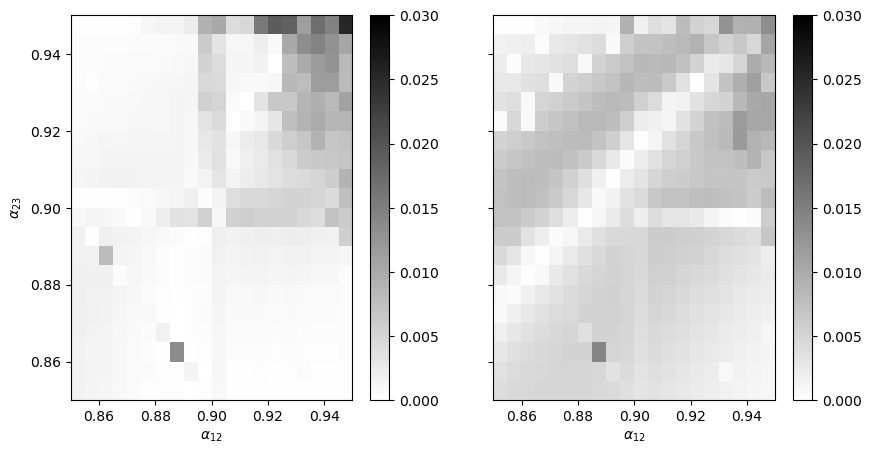

In [34]:
dataframe1 = pd.read_csv('megno_no_breathing.csv', header=None)
data_nb = dataframe1.values.reshape(Ngrid_y,Ngrid_x)
dataframe2 = pd.read_csv('megno_with_breathing.csv', header=None)
data_wb = dataframe2.values.reshape(Ngrid_y,Ngrid_x)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
# f.subplots_adjust(wspace=0)

extent = [min(alpha12),max(alpha12),min(alpha23),max(alpha23)]
ax1.set_xlim(extent[0],extent[1])
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlabel(r"$\alpha_{12}$")
ax1.set_ylabel(r"$\alpha_{23}$")

ax2.set_xlim(extent[0],extent[1])
ax2.set_ylim(extent[2],extent[3])
ax2.set_xlabel(r"$\alpha_{12}$")

im1 = ax1.imshow(data_nb.transpose(), vmin=0, vmax=0.03, interpolation="none", cmap="binary", origin="lower", aspect='auto', extent=extent)
cb1 = plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(data_wb.transpose(), vmin=0, vmax=0.03, interpolation="none", cmap="binary", origin="lower", aspect='auto', extent=extent)
cb2 = plt.colorbar(im2, ax=ax2)

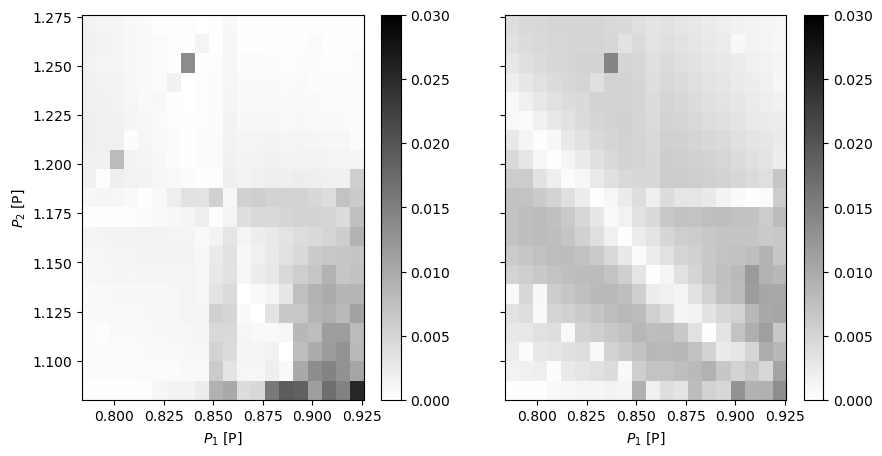

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
# f.subplots_adjust(wspace=0)

extent = [min(alpha12)**(3/2),max(alpha12)**(3/2), 1/min(alpha23)**(3/2), 1/max(alpha23)**(3/2)]
ax1.set_xlim(extent[0],extent[1])
ax1.set_ylim(extent[2], extent[3])
ax1.set_xlabel(r"$P_1$ [P]")
ax1.set_ylabel(r"$P_2$ [P]")

ax2.set_xlim(extent[0],extent[1])
ax2.set_ylim(extent[2], extent[3])
ax2.set_xlabel(r"$P_1$ [P]")

im1 = ax1.imshow(data_nb.transpose(), vmin=0, vmax=0.03, interpolation="none", cmap="binary", origin="lower", aspect='auto', extent=extent)
cb1 = plt.colorbar(im1, ax=ax1)
ax1.invert_yaxis()
im2 = ax2.imshow(data_wb.transpose(), vmin=0, vmax=0.03, interpolation="none", cmap="binary", origin="lower", aspect='auto', extent=extent)
cb2 = plt.colorbar(im2, ax=ax2)